In [24]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Propensity Score Matching

In [25]:
num = 100000
np.random.seed(0)
Z1 = np.random.normal(0, 1, num)
Z2 = np.random.normal(0, 1, num)
log_odds = 2 * Z1 - Z2 + np.random.normal(0, 1, num)
p = 1 / (1 + np.exp(-log_odds))
X = np.random.binomial(1, p)
Y = 3 * X + Z1 + 0.5 * Z2 + np.random.normal(0, 1, num)

df = pd.DataFrame({'Z1': Z1, 'Z2': Z2, 'X': X, 'Y': Y})

In [26]:
# Now, we are going to make a model that assigns propensity scores.
model = LogisticRegression()
model.fit(df[['Z1', 'Z2']], df['X'])
df['propensity_score'] = model.predict_proba(df[['Z1', 'Z2']])[:, 1] # 0 and 1 are probabilities of false and of true

# Now we'll match X = 0 to X = 1
treated = df[df['X'] == 1]
untreated = df[df['X'] == 0]

neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(untreated[['propensity_score']])
distances_treated_cf, indices_treated_cf = neighbors.kneighbors(treated[['propensity_score']])

treated_cf = untreated.iloc[indices_treated_cf.ravel()].reset_index(drop = True)
treated = treated.reset_index(drop=True).copy()
treated.Y.mean() - treated_cf.Y.mean() # treated_cf => untreated items which are the counterfactuals of treated items

3.0205763354894253

In [27]:
distance_treated_cf, indices_treated_cf = neighbors.radius_neighbors(treated[["propensity_score"]], 0.01)
treated.Y.mean() - np.mean([untreated.iloc[arr].Y.mean() for arr in indices_treated_cf if len(untreated.iloc[arr]) > 0])

3.0058855254865158

## Checking balance (we can do this with matching, but not with linear regression!)

In [28]:
pd.concat((treated.mean(), treated_cf.mean()), axis = 1)

,0,1
Z1,0.528904,0.519632
Z2,-0.257774,-0.275110
X,1.000000,0.000000
Y,3.403856,0.383280
propensity_score,0.689250,0.689246


In [6]:
pd.concat((treated.std(), treated_cf.std()), axis = 1)

,0,1
Z1,0.844399,0.829514
Z2,0.963822,0.993123
X,0.000000,0.000000
Y,1.441587,1.437210
propensity_score,0.242074,0.242068


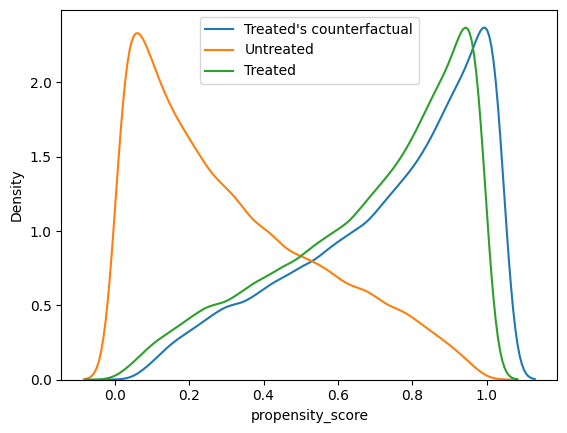

In [31]:
sns.kdeplot(treated_cf.propensity_score + 0.05, label = "Treated's counterfactual")
sns.kdeplot(untreated.propensity_score, label = "Untreated")
sns.kdeplot(treated.propensity_score, label = "Treated")
plt.gca().legend()

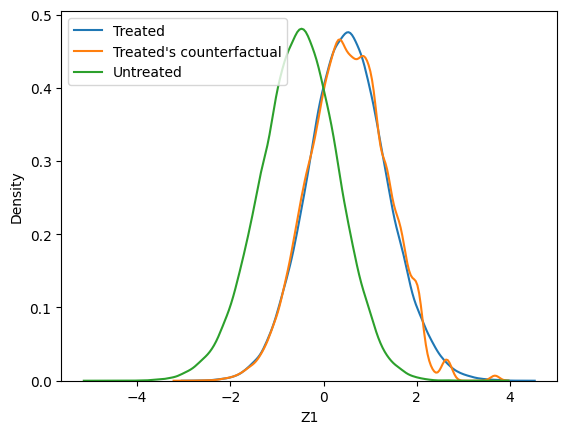

In [12]:
sns.kdeplot(treated.Z1, label = "Treated")
sns.kdeplot(treated_cf.Z1, label = "Treated's counterfactual")
sns.kdeplot(untreated.Z1, label = "Untreated")
plt.gca().legend()

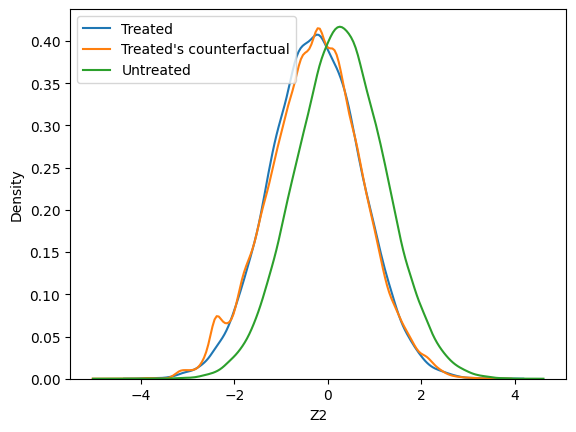

In [13]:
sns.kdeplot(treated.Z2, label = "Treated")
sns.kdeplot(treated_cf.Z2, label = "Treated's counterfactual")
sns.kdeplot(untreated.Z2, label = "Untreated")
plt.gca().legend()

In [24]:
att = np.mean(treated['Y'].values - treated_cf['Y'].values)
print(f"Estimated ATT: {att:.2f}")

Estimated ATT: 3.02


# Inverse Probability Weighting

1.0002904000779287

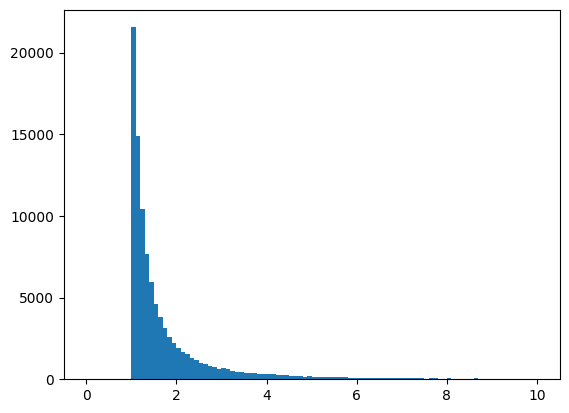

In [14]:
df['ipw'] = (df.X == 1) * (1 / df['propensity_score']) + (df.X == 0) * (1 / (1 - df['propensity_score']))
plt.hist(df.ipw, bins = 100, range = (0, 10))
df.ipw.min()

In [22]:
df.ipw.argmax(), df.ipw.max()

(86383, 258.1835996061756)

In [21]:
df.iloc[df.ipw.argmax()]

Z1                    2.046238
Z2                   -2.396311
X                     0.000000
Y                     1.344587
propensity_score      0.996127
ipw                 258.183600
Name: 86383, dtype: float64

# Weighting with regression

Estimated ATE via IPW: 3.170030
Estimated ATE without matching: 3.7965881825414716


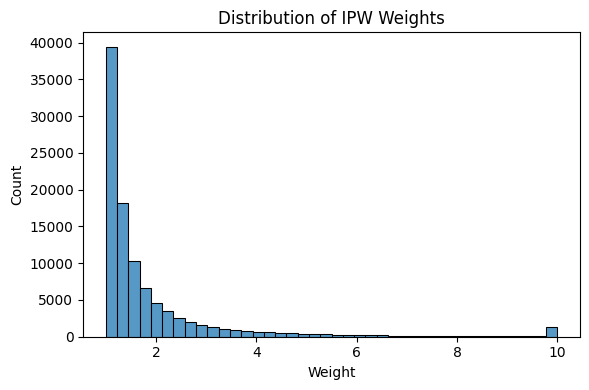

In [17]:
df['ipw'] = np.where(df['X'] == 1, 1 / df['propensity_score'], 1 / (1 - df['propensity_score']))

# If weights are above 10 (probability < 10% or > 90%) it could cause instability - or does this actually not help?
df['ipw_clipped'] = np.clip(df['ipw'], 0, 10)

X_design = sm.add_constant(df['X'])
weighted_model = sm.WLS(df['Y'], X_design, weights=df['ipw_clipped']).fit()
ate_ipw = weighted_model.params['X']
print(f"Estimated ATE via IPW: {ate_ipw:.6f}")
print(f"Estimated ATE without matching: {treated.Y.mean() - untreated.Y.mean()}")

# Plot weights
plt.figure(figsize=(6, 4))
sns.histplot(df['ipw_clipped'], bins=40, kde=False)
plt.title('Distribution of IPW Weights')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Weighting without regression

In [24]:
treated = df[df.X == 1]
untreated = df[df.X == 0]
treated_mean = np.sum(treated['ipw_clipped'] * treated['Y']) / np.sum(treated['ipw_clipped'])
untreated_mean = np.sum(untreated['ipw_clipped'] * untreated['Y']) / np.sum(untreated['ipw_clipped'])
print(f"ATE = {treated_mean - untreated_mean:.6f}")

ATE = 3.170030


# Curse of dimensionality

/var/folders/gf/qd_8fqss2t55m22vdfqdc47m0000gp/T/ipykernel_20011/161412138.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Y"] = df["X"] + df.drop(columns = "X").dot(coefs2) # linear function of the features


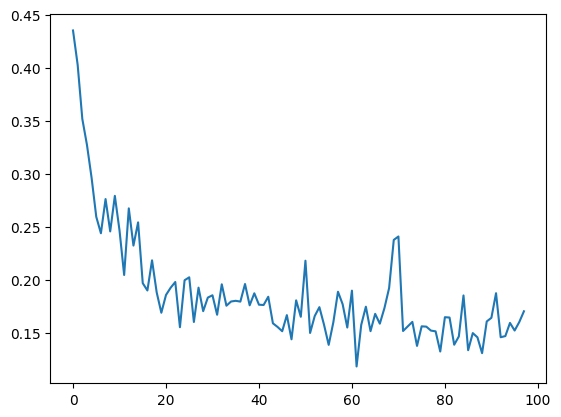

In [25]:
def dimensionality_estimate(dim):
    df = pd.DataFrame()
    coefs1 = np.random.uniform(0, 1, dim)
    coefs2 = np.random.uniform(0, 1, dim)
    num = 1000
    for n in range(dim):
        df[f"Z{n}"] = np.random.normal(0, 1, num)
    # I don't understand why we are computing X and Y, which we then do not use!
    df["X"] = np.random.binomial(1, 1 / (1 + np.exp(df.dot(coefs1)))) # logistic function of the features
    df["Y"] = df["X"] + df.drop(columns = "X").dot(coefs2) # linear function of the features
    rmse_list = list()
    for _ in range(100):
        samp = df.sample(2)
        rmse_list.append(root_mean_squared_error(samp.iloc[0].drop(columns = ["X", "Y"]), samp.iloc[1].drop(columns = ["X", "Y"])))
    return np.std(rmse_list), np.mean(rmse_list)

dimlist = list()
for n in range(2, 100):
    s, m = dimensionality_estimate(n)
    dimlist.append(s / m)

plt.plot(dimlist)

In [75]:
def dimensionality_estimate(dim, with_print = True, with_plot = False):
    df = pd.DataFrame()
    num_Zs = dim
    for n in range(num_Zs):
        df[f"Z{n}"] = np.random.normal(0, 1, (num,))
    confound_coefs = np.random.uniform(0, 1, num_Zs)
    X = np.random.binomial(1, 1 / (1 + np.exp(df.dot(confound_coefs))), (num,)) # logistic function of Zs
    Y_coefs = np.random.uniform(0, 1, num_Zs)
    Y = X + df.dot(Y_coefs) # linear function of Zs
    df["X"] = X
    df["Y"] = Y
    treated = df[df.X == 1]
    untreated = df[df.X == 0]
    neighbors = NearestNeighbors(n_neighbors = 1).fit(untreated.drop(columns = ["Y", "X"]))
    distances_treated_cf, indices_treated_cf = neighbors.kneighbors(treated.drop(columns = ["Y", "X"]))
    treated_cf = untreated.iloc[indices_treated_cf.ravel()].reset_index(drop = True)
    treated = treated.reset_index(drop = True)
    if(with_print):
        print(f"ATT for dim = {dim} is {treated.Y.mean() - treated_cf.Y.mean()}")
    lst = list()
    for n in range(1000):
        samp = df.sample(2)
        rmse = root_mean_squared_error(samp.iloc[0].drop(columns = ["X", "Y"]), samp.iloc[1].drop(columns = ["X", "Y"]))
        lst.append(rmse)
    if(with_plot):
        plt.hist(lst)
    return(np.array(lst).mean(), np.array(lst).std())

In [60]:
for n in range(1, 10):
    dimensionality_estimate(n)

ATT for dim = 1 is 1.000000403622494
ATT for dim = 2 is 0.9998561586829395
ATT for dim = 3 is 0.9904737341540063
ATT for dim = 4 is 0.9776754787276546
ATT for dim = 5 is 0.9243557033018401
ATT for dim = 6 is 0.8872953887698151
ATT for dim = 7 is 0.8454981134191748
ATT for dim = 8 is 0.7535145288184117
ATT for dim = 9 is 0.6323583885150205


In [76]:
sum([dimensionality_estimate(2, with_print = False)[0] for _ in range(20)]) / 20

1.076904984927339

In [77]:
sum([dimensionality_estimate(2, with_print = False)[1] for _ in range(20)]) / 20

0.49847272880586857

In [18]:
dimensionality_estimate(100, with_plot = True)

NameError: name 'dimensionality_estimate' is not defined

In [79]:
# Simpler dataset

In [83]:
def rmse_std_vs_dim(dim, num_samples=1000):
    rmses = []
    for _ in range(num_samples):
        x = np.random.normal(0, 1, dim)
        y = np.random.normal(0, 1, dim)
        rmse = np.sqrt(np.mean((x - y) ** 2))
        rmses.append(rmse)
    return np.mean(rmses), np.std(rmses)

for d in [2, 10, 50, 100]:
    mean_rmse, std_rmse = rmse_std_vs_dim(d)
    print(f"dim={d:3d} | mean RMSE ≈ {mean_rmse:.3f} | std ≈ {std_rmse:.4f}")

dim=  2 | mean RMSE ≈ 1.260 | std ≈ 0.6611
dim= 10 | mean RMSE ≈ 1.379 | std ≈ 0.3092
dim= 50 | mean RMSE ≈ 1.405 | std ≈ 0.1366
dim=100 | mean RMSE ≈ 1.413 | std ≈ 0.0967
